https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
    
Dataset: https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv

In [38]:
# load and plot dataset
import pandas as pd
from matplotlib import pyplot as plt
from datetime import datetime
import math
%matplotlib inline

from sklearn.metrics import mean_squared_error
from sklearn import preprocessing

In [22]:
def parse(inp):
    x = " ".join(list(map(lambda x: str(x), inp)))
    return datetime.strptime(x, '%Y %m %d %H')

In [23]:
data = pd.read_csv('pollution.csv', index_col=0)

In [24]:
data.head()

,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
No,,,,,,,,,,,,
1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [25]:
data["date"] = data[['year','month','day', 'hour']].apply(lambda x:parse(list(x)), axis=1)
data.reset_index(inplace=True, drop=True)
data = data.drop(['year','month','day', 'hour'], axis=1)

In [26]:
data.head()

,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,date
0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [27]:
# manually specify column names
data.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain', "date"]

In [28]:
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,date
0,NaN,-21,-11.0,1021.0,NW,1.79,0,0,2010-01-01 00:00:00
1,NaN,-21,-12.0,1020.0,NW,4.92,0,0,2010-01-01 01:00:00
2,NaN,-21,-11.0,1019.0,NW,6.71,0,0,2010-01-01 02:00:00
3,NaN,-21,-14.0,1019.0,NW,9.84,0,0,2010-01-01 03:00:00
4,NaN,-20,-12.0,1018.0,NW,12.97,0,0,2010-01-01 04:00:00


In [29]:
print(len(data))
print(len(data.dropna()))

43824
41757


In [30]:
data = data.dropna()
data.reset_index(inplace=True, drop=True)

#data['pollution'].fillna(0, inplace=True)
#data = data.dropna()
#data.reset_index(inplace=True,  drop=True)

In [31]:
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,date
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00


In [32]:
data.to_csv('pollution_cleandata.csv')

________

In [72]:
data = pd.read_csv('pollution_cleandata.csv', header=0, index_col=0)
data.head()

,pollution,dew,temp,press,wnd_dir,wnd_spd,snow,rain,date
0,129.0,-16,-4.0,1020.0,SE,1.79,0,0,2010-01-02 00:00:00
1,148.0,-15,-4.0,1020.0,SE,2.68,0,0,2010-01-02 01:00:00
2,159.0,-11,-5.0,1021.0,SE,3.57,0,0,2010-01-02 02:00:00
3,181.0,-7,-5.0,1022.0,SE,5.36,1,0,2010-01-02 03:00:00
4,138.0,-7,-5.0,1022.0,SE,6.25,2,0,2010-01-02 04:00:00


In [73]:
data.index = data["date"]
data = data.drop("date", axis=1)
values = data.values
values

array([[129.0, -16, -4.0, ..., 1.79, 0, 0],
       [148.0, -15, -4.0, ..., 2.68, 0, 0],
       [159.0, -11, -5.0, ..., 3.57, 0, 0],
       ...,
       [10.0, -22, -3.0, ..., 242.7, 0, 0],
       [8.0, -22, -4.0, ..., 246.72, 0, 0],
       [12.0, -21, -3.0, ..., 249.85, 0, 0]], dtype=object)

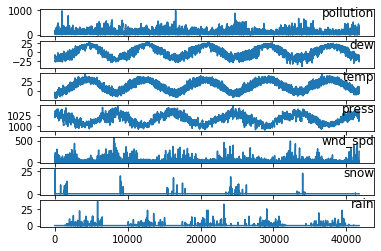

In [74]:
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6,7]
i = 1
# plot each column
plt.figure()
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group])
    plt.title(data.columns[group], y=0.5, loc='right')
    i += 1
plt.show()

_____

Model problem: Predict pollution for the next hour based on pollution level of last hour (stored y for last step) + input features
Alternate Models:
1. Predict pollution for the next hour based on pollution level of last 24 hours (stored y for last 24 steps/define steps of 24 hours) + input features
2. Predict the pollution for the next hour based on the “expected” weather conditions for the next hour.

In [75]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]


    agg = pd.concat(cols, axis=1)
    agg.columns = names
    

    if dropnan:
        agg.dropna(inplace=True) 
    return agg
 
    
    
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.129779   0.352941   0.245902   0.527273   0.666667   0.002372   
2   0.148893   0.367647   0.245902   0.527273   0.666667   0.003947   
3   0.159960   0.426471   0.229508   0.545454   0.666667   0.005522   
4   0.182093   0.485294   0.229508   0.563637   0.666667   0.008690   
5   0.138833   0.485294   0.229508   0.563637   0.666667   0.010265   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.000000        0.0  0.148893  
2   0.000000        0.0  0.159960  
3   0.000000        0.0  0.182093  
4   0.037037        0.0  0.138833  
5   0.074074        0.0  0.109658  


In [ ]:
tf.keras.layers.LSTM?

In [76]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 8) (8760,) (32996, 1, 8) (32996,)


Epoch 1/50
122/122 - 1s - loss: 0.0537 - val_loss: 0.0504
Epoch 2/50
122/122 - 1s - loss: 0.0395 - val_loss: 0.0478
Epoch 3/50
122/122 - 1s - loss: 0.0243 - val_loss: 0.0496
Epoch 4/50
122/122 - 1s - loss: 0.0162 - val_loss: 0.0371
Epoch 5/50
122/122 - 1s - loss: 0.0149 - val_loss: 0.0255
Epoch 6/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0182
Epoch 7/50
122/122 - 1s - loss: 0.0145 - val_loss: 0.0166
Epoch 8/50
122/122 - 1s - loss: 0.0144 - val_loss: 0.0158
Epoch 9/50
122/122 - 1s - loss: 0.0143 - val_loss: 0.0151
Epoch 10/50
122/122 - 1s - loss: 0.0143 - val_loss: 0.0144
Epoch 11/50
122/122 - 1s - loss: 0.0143 - val_loss: 0.0142
Epoch 12/50
122/122 - 1s - loss: 0.0143 - val_loss: 0.0139
Epoch 13/50
122/122 - 1s - loss: 0.0142 - val_loss: 0.0141
Epoch 14/50
122/122 - 1s - loss: 0.0144 - val_loss: 0.0142
Epoch 15/50
122/122 - 1s - loss: 0.0144 - val_loss: 0.0140
Epoch 16/50
122/122 - 1s - loss: 0.0142 - val_loss: 0.0141
Epoch 17/50
122/122 - 1s - loss: 0.0143 - val_loss: 0.0142
Epoch 

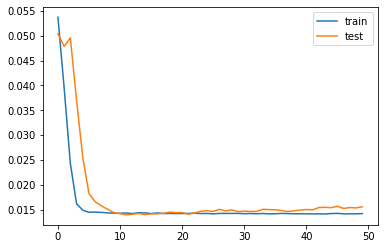

In [77]:
# design network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [78]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 25.922


In [131]:
yhat

array([[0.06848934],
       [0.06745508],
       [0.05533218],
       ...,
       [0.00995452],
       [0.0099365 ],
       [0.0081452 ]], dtype=float32)

Text(0, 0.5, 'Predictions')

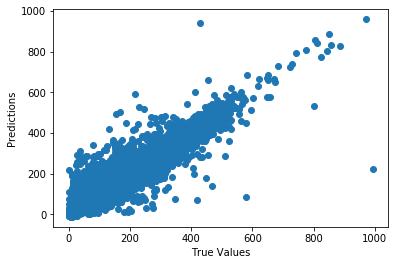

In [136]:
plt.scatter(inv_y, inv_yhat)
plt.xlabel('True Values')
plt.ylabel('Predictions')

In [141]:
# split into train and test sets
values = reframed.values
n_train_hours = 3*365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 8) (26280,) (15476, 1, 8) (15476,)


Epoch 1/50
365/365 - 1s - loss: 0.0372 - val_loss: 0.0339
Epoch 2/50
365/365 - 1s - loss: 0.0152 - val_loss: 0.0145
Epoch 3/50
365/365 - 1s - loss: 0.0142 - val_loss: 0.0128
Epoch 4/50
365/365 - 1s - loss: 0.0142 - val_loss: 0.0127
Epoch 5/50
365/365 - 1s - loss: 0.0142 - val_loss: 0.0127
Epoch 6/50
365/365 - 1s - loss: 0.0142 - val_loss: 0.0128
Epoch 7/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0128
Epoch 8/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0129
Epoch 9/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0129
Epoch 10/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0130
Epoch 11/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0131
Epoch 12/50
365/365 - 1s - loss: 0.0142 - val_loss: 0.0132
Epoch 13/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0132
Epoch 14/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0131
Epoch 15/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0132
Epoch 16/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0132
Epoch 17/50
365/365 - 1s - loss: 0.0141 - val_loss: 0.0133
Epoch 

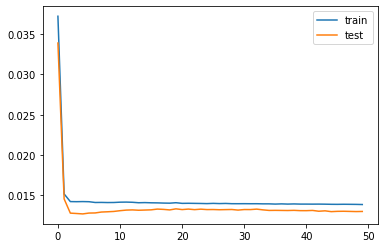

In [142]:
# design network
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tf.keras.layers.Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [143]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 21.572


Text(0, 0.5, 'Predictions')

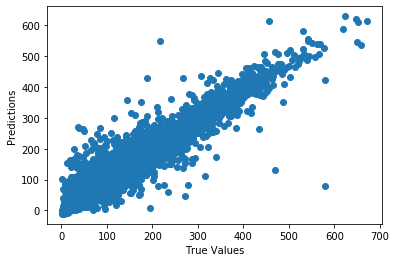

In [144]:
plt.scatter(inv_y, inv_yhat)
plt.xlabel('True Values')
plt.ylabel('Predictions')

______________

https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/keras/regression.ipynb

In [146]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [147]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


In [148]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

In [149]:
pwd

'D:\\AI_Fundamentals'

In [150]:
dataset_path = keras.utils.get_file("D:\\AI_Fundamentals\\auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path


'D:\\AI_Fundamentals\\auto-mpg.data'

In [151]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight', 'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,na_values = "?", comment='\t', sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [152]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [153]:
dataset = dataset.dropna()

In [154]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [155]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [156]:
dataset = pd.get_dummies(dataset, prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


In [157]:
y = [0, 1, 2, 3]
tf.keras.utils.to_categorical(y, num_classes=4)

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]], dtype=float32)

In [158]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

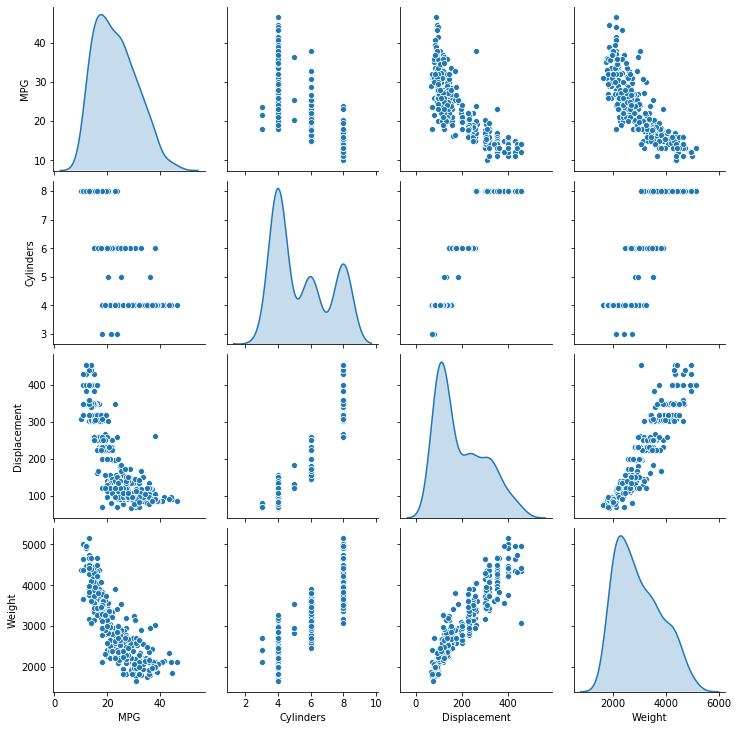

In [159]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [160]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [161]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [162]:
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [163]:
def build_model():
    model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

model = build_model()
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 64)                640       
_________________________________________________________________
dense_13 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_14 (Dense)             (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [164]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:572.6305,  mae:22.6147,  mse:572.6305,  val_loss:569.6857,  val_mae:22.5227,  val_mse:569.6857,  
....................................................................................................
Epoch: 100, loss:6.0681,  mae:1.7454,  mse:6.0681,  val_loss:8.4749,  val_mae:2.2442,  val_mse:8.4749,  
....................................................................................................
Epoch: 200, loss:5.5057,  mae:1.6034,  mse:5.5057,  val_loss:8.3182,  val_mae:2.1079,  val_mse:8.3182,  
....................................................................................................
Epoch: 300, loss:4.7233,  mae:1.4785,  mse:4.7233,  val_loss:8.4581,  val_mae:2.1488,  val_mse:8.4581,  
....................................................................................................
Epoch: 400, loss:4.2669,  mae:1.3919,  mse:4.2669,  val_loss:8.2857,  val_mae:2.2022,  val_mse:8.2857,  
..............................................................

Text(0, 0.5, 'MSE [MPG^2]')

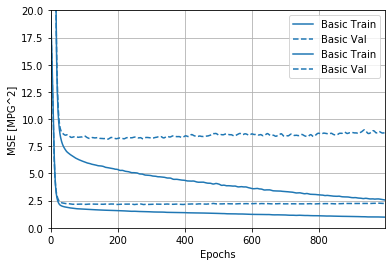

In [165]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 20])
plt.ylabel('MSE [MPG^2]')

Early Stopping

In [166]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])


Epoch: 0, loss:582.5096,  mae:22.8459,  mse:582.5096,  val_loss:575.5508,  val_mae:22.6432,  val_mse:575.5508,  
.............................................................................................

Text(0, 0.5, 'MAE [MPG]')

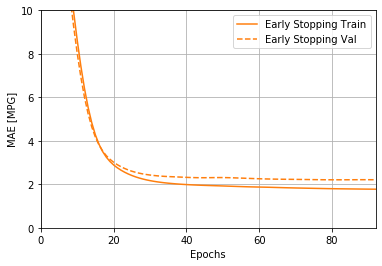

In [167]:
plotter.plot({'Early Stopping': early_history}, metric = "mae")
plt.ylim([0, 10])
plt.ylabel('MAE [MPG]')

In [168]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

3/3 - 0s - loss: 6.0768 - mae: 1.9309 - mse: 6.0768
Testing set Mean Abs Error:  1.93 MPG


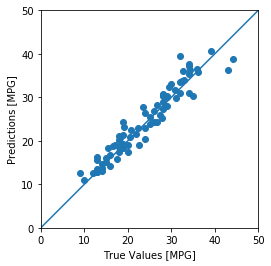

In [171]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


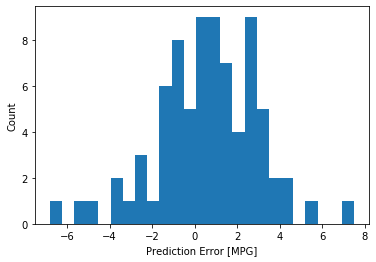

In [170]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")